In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sympy as sp
from sympy import symbols

import pandas as pd
import math
import time

from mpl_toolkits.mplot3d import Axes3D


plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["font.size"] = 12

# Аналитический этап

символьное задание функции, градиента и Гессе

In [2]:
x, y = sp.symbols('x y', real=True)

f_sym = (2*x + y**2) * sp.exp(-x**2 - y**2)

In [3]:
print('\nградиент и матрица Гессе')
grad_sym = (sp.diff(f_sym, x), sp.diff(f_sym, y))
H_sym = sp.hessian(f_sym, (x, y))

f_sym
grad_sym,
H_sym


градиент и матрица Гессе


Matrix([
[4*x**2*(2*x + y**2)*exp(-x**2 - y**2) - 8*x*exp(-x**2 - y**2) - 2*(2*x + y**2)*exp(-x**2 - y**2),                                    4*x*y*(2*x + y**2)*exp(-x**2 - y**2) - 4*x*y*exp(-x**2 - y**2) - 4*y*exp(-x**2 - y**2)],
[          4*x*y*(2*x + y**2)*exp(-x**2 - y**2) - 4*x*y*exp(-x**2 - y**2) - 4*y*exp(-x**2 - y**2), 4*y**2*(2*x + y**2)*exp(-x**2 - y**2) - 8*y**2*exp(-x**2 - y**2) - 2*(2*x + y**2)*exp(-x**2 - y**2) + 2*exp(-x**2 - y**2)]])

1. Находим стационарные точки (решаем систему ∂F/∂x = 0, ∂F/∂y = 0)  
2. В каждой точке считаем Гессе  
3. По собственным значениям Гессе определяем тип точки (минимум, максимум, седло)


**стационарные точки**

In [4]:
critical_points = sp.solve(
    [sp.Eq(grad_sym[0], 0), sp.Eq(grad_sym[1], 0)],
    (x, y),
    dict=True
)

print("стационарные точки:")
for cp in critical_points:
    print(cp)

стационарные точки:
{x: -sqrt(2)/2, y: 0}
{x: sqrt(2)/2, y: 0}


**классификация точки по знаку собственных значений Гессе**

In [5]:
def classify_point(point):
    H_at_point = H_sym.subs({x: point[x], y: point[y]})
    eigvals = [ev.evalf() for ev in H_at_point.eigenvals().keys()]

    pos = all(ev > 0 for ev in eigvals)
    neg = all(ev < 0 for ev in eigvals)

    if pos:
        tp = "локальный минимум"
    elif neg:
        tp = "локальный максимум"
    else:
        tp = "условие достаточного экстремума не выполнено"

    return H_at_point, eigvals, tp

print("\nклассификация стационарных точек:")
for cp in critical_points:
    H_p, evs, tp = classify_point(cp)
    print(f"\nточка: {cp}")
    print("H =", H_p)
    print("собственные значения:", evs)
    print("тип точки:", tp)


классификация стационарных точек:

точка: {x: -sqrt(2)/2, y: 0}
H = Matrix([[4*sqrt(2)*exp(-1/2), 0], [0, 2*exp(-1/2) + 2*sqrt(2)*exp(-1/2)]])
собственные значения: [3.43105553984283, 2.92858908934668]
тип точки: локальный минимум

точка: {x: sqrt(2)/2, y: 0}
H = Matrix([[-4*sqrt(2)*exp(-1/2), 0], [0, -2*sqrt(2)*exp(-1/2) + 2*exp(-1/2)]])
собственные значения: [-3.43105553984283, -0.502466450496147]
тип точки: локальный максимум


# Практический этап

1. Строим график функции и линии уровня, отмечаем стационарные точки
2. Показываем, что направление наискорейшего возрастания совпадает с градиентом, а убывания с антиградиентом
3. Закладываем сохранение всех точек приближения и числа итераций
4. Реализуем три варианта градиентного спуска:
   - постоянный шаг
   - шаг с делением в процессе
   - метод наискорейшего спуска (поиск оптимального шага)
   - методы Полака–Райбера и Флетчера–Ривса


**численные версии функции и градиента**

In [6]:
F_np = sp.lambdify((x, y), f_sym, "numpy")
grad_np = sp.lambdify((x, y), [grad_sym[0], grad_sym[1]], "numpy")

def f_vec(point: np.ndarray) -> float:
    return float(F_np(point[0], point[1]))

def grad_vec(point: np.ndarray) -> np.ndarray:
    g = grad_np(point[0], point[1])
    return np.array(g, dtype=float)


**стационарные точки (для отметки на графике)**

In [7]:
critical_points = sp.solve(
    [sp.Eq(grad_sym[0], 0), sp.Eq(grad_sym[1], 0)],
    (x, y),
    dict=True
)

print("стационарные точки:")
for cp in critical_points:
    print(cp)

стационарные точки:
{x: -sqrt(2)/2, y: 0}
{x: sqrt(2)/2, y: 0}


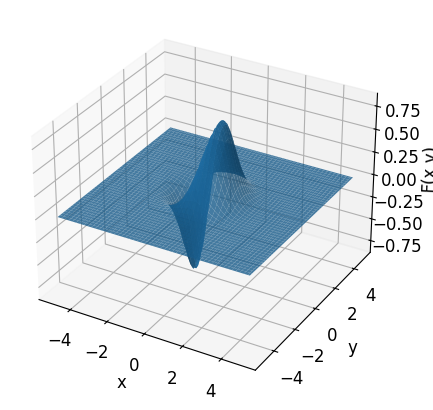

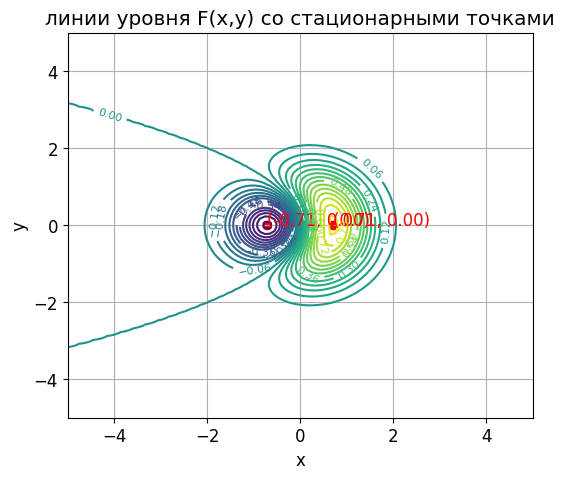

In [8]:
x_min, x_max = -5, 5
y_min, y_max = -5, 5

xs = np.linspace(x_min, x_max, 100)
ys = np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(xs, ys)
Z = F_np(X, Y)


fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("F(x,y)")
plt.show()

# линии уровня
plt.figure(figsize=(6, 5))
CS = plt.contour(X, Y, Z, levels=30)
plt.clabel(CS, inline=True, fontsize=8)

for cp in critical_points:
    cx = float(cp[x])
    cy = float(cp[y])
    plt.scatter(cx, cy, color="red")
    plt.text(cx, cy, f"({cx:.2f}, {cy:.2f})", color="red")

plt.xlabel("x")
plt.ylabel("y")
plt.title("линии уровня F(x,y) со стационарными точками")
plt.grid(True)
plt.show()


**численная демонстрация «градиент vs антиградиент»**

**точка в которой смотрим направление максимального возрастания**

In [9]:
point = np.array([1.0, 1.0])
g = grad_vec(point)

print("градиент в точке:", g)

градиент в точке: [-0.54134113 -0.54134113]


нормированный градиент (направление наискорейшего возрастания)

In [10]:
u_grad = g / np.linalg.norm(g)

антиградиент


In [11]:
u_anti = -u_grad

In [12]:
def directional_derivative(f, x, u, eps=1e-6):
    return (f(x + eps*u) - f(x - eps*u)) / (2*eps)

print("производная по направлению градиента",
      directional_derivative(f_vec, point, u_grad))
print("производная по направлению антиградиента",
      directional_derivative(f_vec, point, u_anti))


производная по направлению градиента 0.7655719720944809
производная по направлению антиградиента -0.7655719720944809


## 3. Хранение всех точек приближения

Во всех алгоритмах будем:
- возвращать список точек `history`
- возвращать значения `f` на этих точках
- возвращать число итераций `n_iter`

Это нужно и для отчета, и для построения траекторий на графике


вспомогательная функция для отрисовки траектории

In [13]:
def plot_contours_with_path(f, history, xlim, ylim, levels=40, title=None):
    xs = np.linspace(xlim[0], xlim[1], 200)
    ys = np.linspace(ylim[0], ylim[1], 200)
    X, Y = np.meshgrid(xs, ys)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = f(np.array([X[i, j], Y[i, j]]))

    plt.figure(figsize=(6, 5))
    plt.contour(X, Y, Z, levels=levels)
    h = np.array(history)
    plt.plot(h[:, 0], h[:, 1], marker="o")

    if title is not None:
        plt.title(title)

    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()


## 4. Градиентные спуски

Общий вид шага

$$
x^{k+1} = x^k - \alpha_k \nabla f(x^k)
$$

Реализуем варианты:

1. `strategy="constant"` — αᵏ = const  
2. `strategy="divide"` — αᵏ постепенно делим на число (backtracking line search)  
3. `strategy="line_search"` — метод наискорейшего спуска (поиск α как arg min f(xᵏ − α ∇f(xᵏ)))


общая функция градиентного спуска

In [14]:
def gradient_descent(
    f,
    grad_f,
    x0,
    alpha0=0.1,
    tol=1e-6,
    max_iter=1000,
    strategy="constant",
    divide_factor=2.0,
    line_search_max_alpha=1.0,
):


    x = np.asarray(x0, dtype=float)
    history = [x.copy()]
    values = [f(x)]

    def line_search_alpha(x, g):
        # метод золотого сечения: min по α f(x - α g) на [0, line_search_max_alpha]
        a, b = 0.0, line_search_max_alpha
        phi = (1 + np.sqrt(5)) / 2
        invphi = 1 / phi

        c = b - (b - a) * invphi
        d = a + (b - a) * invphi
        fc = f(x - c * g)
        fd = f(x - d * g)

        for _ in range(40):
            if fc < fd:
                b, d, fd = d, c, fc
                c = b - (b - a) * invphi
                fc = f(x - c * g)
            else:
                a, c, fc = c, d, fd
                d = a + (b - a) * invphi
                fd = f(x - d * g)

        return (a + b) / 2

    alpha = alpha0

    for k in range(max_iter):
        g = np.asarray(grad_f(x), dtype=float)
        if np.linalg.norm(g) < tol:
            break

        if strategy == "constant":
            pass  # alpha остаётся alpha0

        elif strategy == "divide":
            # backtracking если шаг не уменьшает функцию то делим alpha на число
            alpha = alpha0
            while f(x - alpha*g) >= f(x):
                alpha /= divide_factor
                if alpha < 1e-12:
                    break

        elif strategy == "line_search":
            alpha = line_search_alpha(x, g)

        else:
            raise ValueError("Unknown strategy")

        x = x - alpha * g
        history.append(x.copy())
        values.append(f(x))

    return np.array(history), np.array(values), k + 1


## Методы Полака–Райбера и Флетчера–Ривса

Оба метода это вариации метода сопряжённых градиентов

Общий вид
- направление d₀ = −g₀
- на шаге k ищем αₖ = arg min f(xₖ + α dₖ)
- xₖ₊₁ = xₖ + αₖ dₖ
- gₖ₊₁ = ∇f(xₖ₊₁)
- βₖ₊₁ задаётся по разным формулам

Флетчер–Ривс  
$$
\beta_{k+1}^{FR} = \frac{\|g_{k+1}\|^2}{\|g_k\|^2}
$$

Полак–Райбер  
$$
\beta_{k+1}^{PR} = \frac{g_{k+1}^\top (g_{k+1} - g_k)}{\|g_k\|^2}
$$


In [15]:
def conjugate_gradient(
    f,
    grad_f,
    x0,
    tol=1e-6,
    max_iter=1000,
    line_search_max_alpha=1.0,
    beta_type="FR",
):
    x = np.asarray(x0, dtype=float)
    g = np.asarray(grad_f(x), dtype=float)
    d = -g.copy()

    history = [x.copy()]
    values = [f(x)]

    def line_search_alpha(x, d):
        a, b = 0.0, line_search_max_alpha
        phi = (1 + np.sqrt(5)) / 2
        invphi = 1 / phi

        c = b - (b - a) * invphi
        d_ = a + (b - a) * invphi
        fc = f(x + c * d)
        fd = f(x + d_ * d)

        for _ in range(40):
            if fc < fd:
                b, d_, fd = d_, c, fc
                c = b - (b - a) * invphi
                fc = f(x + c * d)
            else:
                a, c, fc = c, d_, fd
                d_ = a + (b - a) * invphi
                fd = f(x + d_ * d)

        return (a + b) / 2

    for k in range(max_iter):
        if np.linalg.norm(g) < tol:
            break

        alpha = line_search_alpha(x, d)
        x = x + alpha * d
        g_new = np.asarray(grad_f(x), dtype=float)

        if beta_type == "FR":
            beta = np.dot(g_new, g_new) / max(np.dot(g, g), 1e-16)
        elif beta_type == "PR":
            beta = np.dot(g_new, g_new - g) / max(np.dot(g, g), 1e-16)
        else:
            raise ValueError("beta_type must be 'FR' or 'PR'")

        d = -g_new + beta * d
        g = g_new

        history.append(x.copy())
        values.append(f(x))

    return np.array(history), np.array(values), k + 1


In [16]:
x0 = np.array([0.0, 0.0])

hist_const, vals_const, it_const = gradient_descent(
    f_vec, grad_vec, x0,
    alpha0=0.05,
    tol=1e-6,
    max_iter=5000,
    strategy="constant",
)

hist_div, vals_div, it_div = gradient_descent(
    f_vec, grad_vec, x0,
    alpha0=0.1,
    tol=1e-6,
    max_iter=5000,
    strategy="divide",
    divide_factor=2.0,
)

hist_ls, vals_ls, it_ls = gradient_descent(
    f_vec, grad_vec, x0,
    alpha0=0.1,
    tol=1e-6,
    max_iter=1000,
    strategy="line_search",
    line_search_max_alpha=1.0,
)

hist_fr, vals_fr, it_fr = conjugate_gradient(
    f_vec, grad_vec, x0,
    tol=1e-6,
    max_iter=1000,
    beta_type="FR",
)

hist_pr, vals_pr, it_pr = conjugate_gradient(
    f_vec, grad_vec, x0,
    tol=1e-6,
    max_iter=1000,
    beta_type="PR",
)




постоянный шаг, итераций = 79 x* = [-0.70710653  0.        ] f* = -0.857763884960595


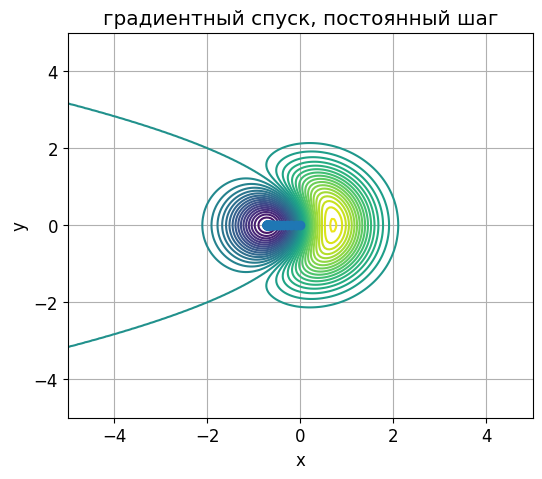

In [17]:
print("постоянный шаг, итераций =", it_const, "x* =", hist_const[-1], "f* =", vals_const[-1])
plot_contours_with_path(f_vec, hist_const, [x_min, x_max], [y_min, y_max], title="градиентный спуск, постоянный шаг")

деление шага, итераций = 36 x* = [-0.70710653  0.        ] f* = -0.8577638849605983


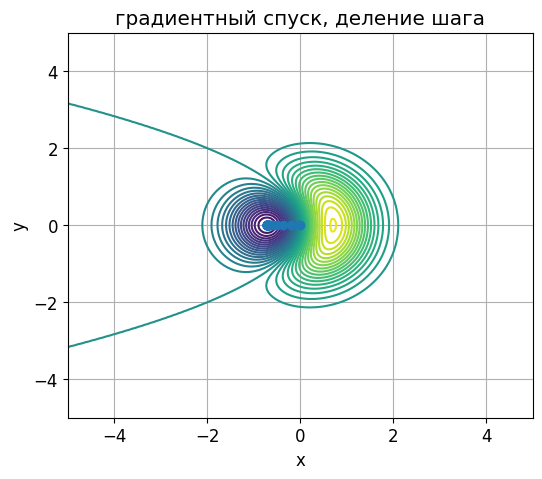

In [18]:
print("деление шага, итераций =", it_div,   "x* =", hist_div[-1],   "f* =", vals_div[-1])
plot_contours_with_path(f_vec, hist_div,   [x_min, x_max], [y_min, y_max], title="градиентный спуск, деление шага")

Наиск. спуск, итераций = 2 x* = [-0.70710678  0.        ] f* = -0.8577638849607068


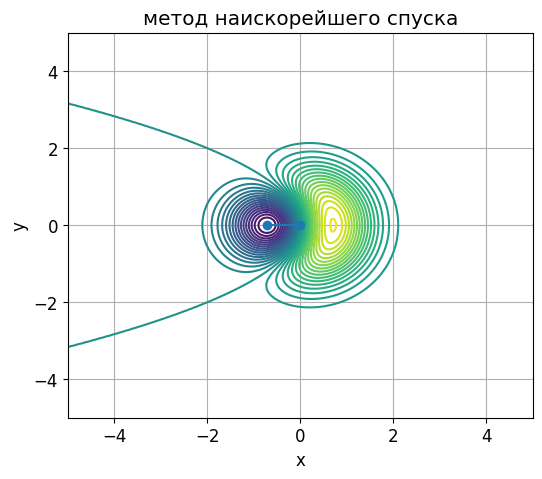

In [19]:
print("Наиск. спуск, итераций =", it_ls,    "x* =", hist_ls[-1],    "f* =", vals_ls[-1])
plot_contours_with_path(f_vec, hist_ls,    [x_min, x_max], [y_min, y_max], title="метод наискорейшего спуска")

Флетчер–Ривс, итераций = 2 x* = [-0.70710678  0.        ] f* = -0.8577638849607068


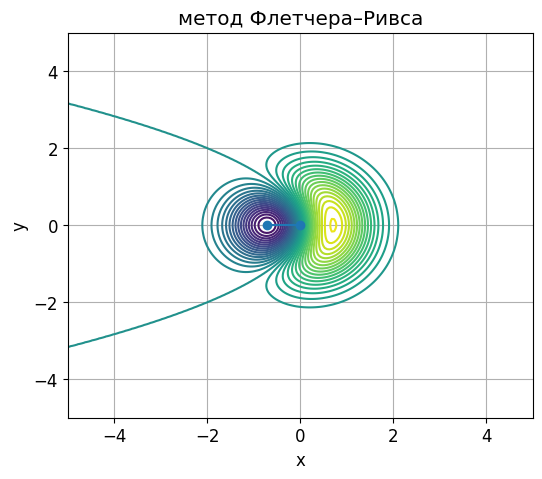

In [20]:
print("Флетчер–Ривс, итераций =", it_fr,    "x* =", hist_fr[-1],    "f* =", vals_fr[-1])
plot_contours_with_path(f_vec, hist_fr,    [x_min, x_max], [y_min, y_max], title="метод Флетчера–Ривса")

Полак–Райбер, итераций = 2 x* = [-0.70710678  0.        ] f* = -0.8577638849607068


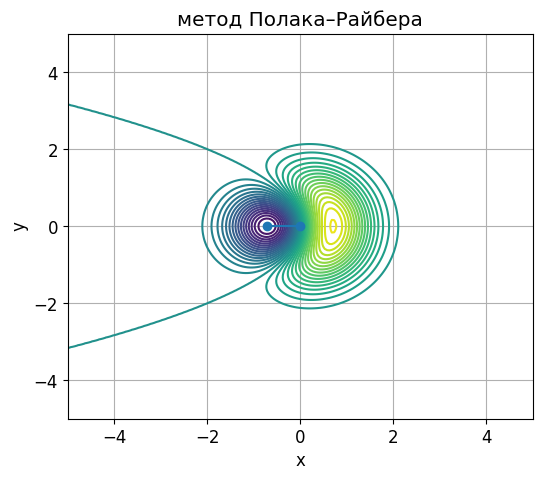

In [21]:
print("Полак–Райбер, итераций =", it_pr,    "x* =", hist_pr[-1],    "f* =", vals_pr[-1])
plot_contours_with_path(f_vec, hist_pr,    [x_min, x_max], [y_min, y_max], title="метод Полака–Райбера")

# 5–7. Тестирование методов на функции из условия

5. Проводим тестирование всех реализованных методов на функции из условия  
6. Сравниваем численное решение с аналитическим минимумом  
7. На графике показываем траекторию движения текущего приближения для каждого алгоритма и обсуждаем особенности


**находим стационарные точки ещё раз и классифицируем, чтобы выбрать минимум**

In [22]:
critical_points = sp.solve(
    [sp.Eq(grad_sym[0], 0), sp.Eq(grad_sym[1], 0)],
    (x, y),
    dict=True
)

print("стационарные точки функции из условия")
for cp in critical_points:
    print(cp)

стационарные точки функции из условия
{x: -sqrt(2)/2, y: 0}
{x: sqrt(2)/2, y: 0}


**классифицируем стационарную точку по знакам собственных значений Гессе**

In [23]:
def classify_point(point_dict):

    H_at = H_sym.subs({x: point_dict[x], y: point_dict[y]})
    eigvals = [ev.evalf() for ev in H_at.eigenvals().keys()]
    pos = all(ev > 0 for ev in eigvals)
    neg = all(ev < 0 for ev in eigvals)
    if pos:
        tp = "локальный минимум"
    elif neg:
        tp = "локальный максимум"
    else:
        tp = "седловая / вырожденная точка"
    return H_at, eigvals, tp

print("\nклассификация стационарных точек:")
analytic_min_points = []
for cp in critical_points:
    H_at, eigvals, tp = classify_point(cp)
    value = f_sym.subs({x: cp[x], y: cp[y]}).evalf()
    print(f"\nточка: {cp}")
    print("тип:", tp)
    print("собственные значения H:", eigvals)
    print("F(x,y) в точке:", value)
    if "минимум" in tp:
        analytic_min_points.append((cp, float(value)))

analytic_min_points



классификация стационарных точек:

точка: {x: -sqrt(2)/2, y: 0}
тип: локальный минимум
собственные значения H: [3.43105553984283, 2.92858908934668]
F(x,y) в точке: -0.857763884960707

точка: {x: sqrt(2)/2, y: 0}
тип: локальный максимум
собственные значения H: [-3.43105553984283, -0.502466450496147]
F(x,y) в точке: 0.857763884960707


[({x: -sqrt(2)/2, y: 0}, -0.8577638849607068)]

**запуск методов на функции из условия и сравнение с аналитическим минимумом**

**выбераем одну аналитическую точку минимума**

In [24]:
if len(analytic_min_points) == 0:
    raise RuntimeError("не найден аналитический минимум")
analytic_point_dict, analytic_f_val = analytic_min_points[0]

x_analytic = np.array([float(analytic_point_dict[x]), float(analytic_point_dict[y])])
print("аналитический минимум:")
print("x* =", x_analytic)
print("F(x*) =", analytic_f_val)

аналитический минимум:
x* = [-0.70710678  0.        ]
F(x*) = -0.8577638849607068


In [25]:
x0_main = np.array([1.0, 1.0])

tol_main = 1e-6

hist_const, vals_const, it_const = gradient_descent(
    f_vec, grad_vec, x0_main,
    alpha0=0.1,
    tol=tol_main,
    max_iter=10000,
    strategy="constant",
)

hist_div, vals_div, it_div = gradient_descent(
    f_vec, grad_vec, x0_main,
    alpha0=0.2,
    tol=tol_main,
    max_iter=10000,
    strategy="divide",
    divide_factor=2.0,
)

hist_ls, vals_ls, it_ls = gradient_descent(
    f_vec, grad_vec, x0_main,
    alpha0=0.1,
    tol=tol_main,
    max_iter=2000,
    strategy="line_search",
    line_search_max_alpha=2.0,
)

hist_fr, vals_fr, it_fr = conjugate_gradient(
    f_vec, grad_vec, x0_main,
    tol=tol_main,
    max_iter=2000,
    beta_type="FR",
)

hist_pr, vals_pr, it_pr = conjugate_gradient(
    f_vec, grad_vec, x0_main,
    tol=tol_main,
    max_iter=2000,
    beta_type="PR",
)

def print_result(name, history, values, iters):
    x_star = history[-1]
    f_star = values[-1]
    dist = np.linalg.norm(x_star - x_analytic)
    diff_f = abs(f_star - analytic_f_val)
    print(f"{name:18s}: итераций = {iters:4d}, "
          f"x* = {x_star}, F(x*) = {f_star:.6e}, "
          f"|x* - x_analytic| = {dist:.2e}, |F - F_analytic| = {diff_f:.2e}")

print_result("GD const",   hist_const, vals_const, it_const)
print_result("GD divide",  hist_div,   vals_div,   it_div)
print_result("GD line",    hist_ls,    vals_ls,    it_ls)
print_result("CG Fletcher",hist_fr,    vals_fr,    it_fr)
print_result("CG Polak",   hist_pr,    vals_pr,    it_pr)


GD const          : итераций = 10000, x* = [2.6287029  2.48192056], F(x*) = 2.406202e-05, |x* - x_analytic| = 4.16e+00, |F - F_analytic| = 8.58e-01
GD divide         : итераций = 10000, x* = [2.70890351 2.55899421], F(x*) = 1.114501e-05, |x* - x_analytic| = 4.27e+00, |F - F_analytic| = 8.58e-01
GD line           : итераций = 2000, x* = [2.73422723 2.69120422], F(x*) = 5.152089e-06, |x* - x_analytic| = 4.37e+00, |F - F_analytic| = 8.58e-01
CG Fletcher       : итераций =  890, x* = [3.11621417 2.98984529], F(x*) = 1.206297e-07, |x* - x_analytic| = 4.85e+00, |F - F_analytic| = 8.58e-01
CG Polak          : итераций = 2000, x* = [2.68858957 2.58107312], F(x*) = 1.116986e-05, |x* - x_analytic| = 4.27e+00, |F - F_analytic| = 8.58e-01


# 7. траектории всех методов на одной функции

In [26]:
x_min, x_max = -3, 3
y_min, y_max = -3, 3

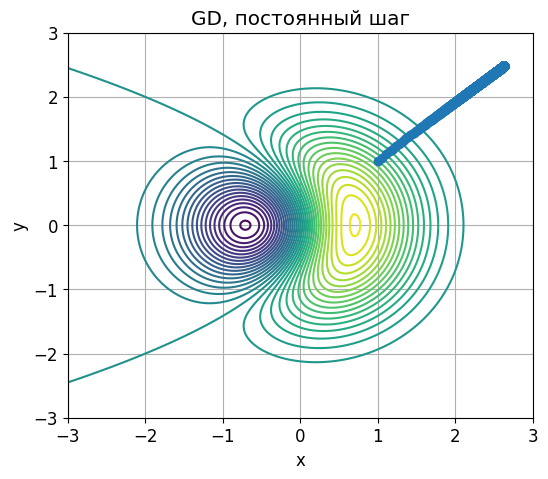

In [27]:
plot_contours_with_path(f_vec, hist_const, [x_min, x_max], [y_min, y_max],
                        title="GD, постоянный шаг")

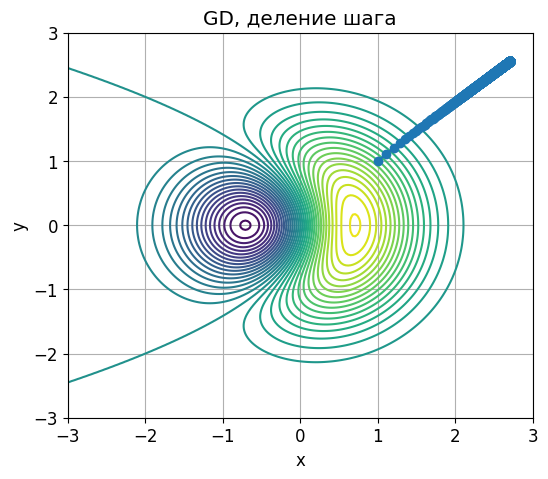

In [28]:
plot_contours_with_path(f_vec, hist_div, [x_min, x_max], [y_min, y_max],
                        title="GD, деление шага")

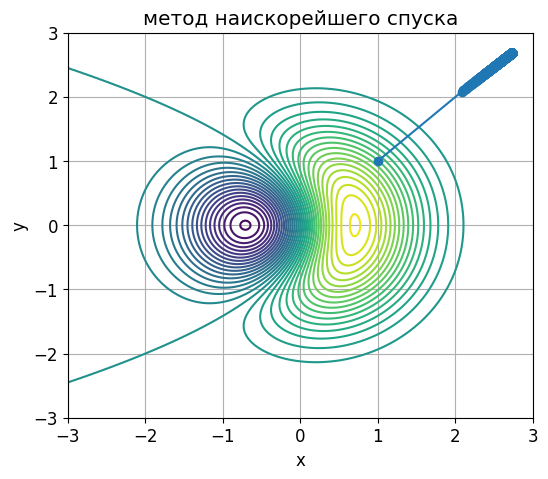

In [29]:
plot_contours_with_path(f_vec, hist_ls, [x_min, x_max], [y_min, y_max],
                        title="метод наискорейшего спуска")

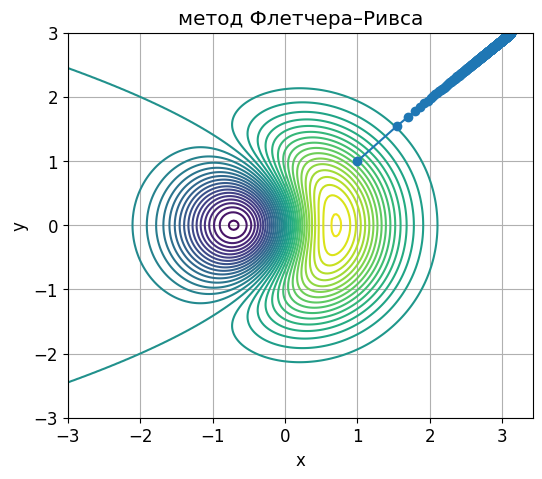

In [30]:
plot_contours_with_path(f_vec, hist_fr, [x_min, x_max], [y_min, y_max],
                        title="метод Флетчера–Ривса")

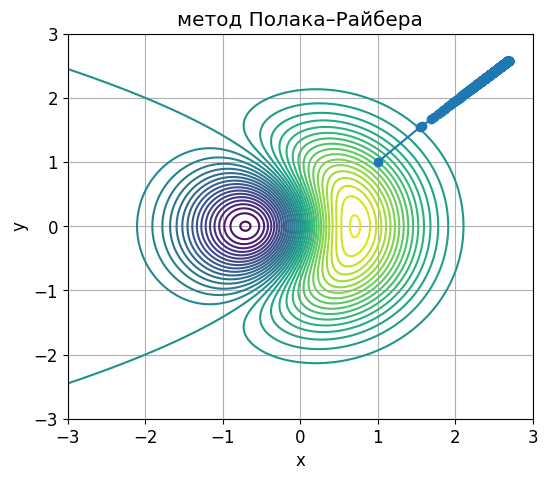

In [31]:
plot_contours_with_path(f_vec, hist_pr, [x_min, x_max], [y_min, y_max],
                        title="метод Полака–Райбера")

# 8. Тестирование алгоритмов на стандартных функциях

Реализованны

- Функция Розенброка  
- Функция Растригина  
- Функция Бута  
- Eggholder  
- Функция с плохим масштабом  
- Функция Изома  
- Та самая задача из КР  


**численный градиент**

In [32]:
def numerical_grad(f, x, eps=1e-6):
    x = np.asarray(x, dtype=float)
    g = np.zeros_like(x)
    for i in range(len(x)):
        dx = np.zeros_like(x)
        dx[i] = eps
        g[i] = (f(x + dx) - f(x - dx)) / (2 * eps)
    return g


**сами тестовые функции и их градиенты**

In [33]:
# 1. Розенброка
def rosenbrock(x):
    x0, x1 = x
    return (1 - x0)**2 + 100 * (x1 - x0**2)**2

def grad_rosenbrock(x):
    x0, x1 = x
    df_dx0 = -2*(1 - x0) - 400*x0*(x1 - x0**2)
    df_dx1 = 200*(x1 - x0**2)
    return np.array([df_dx0, df_dx1])

In [34]:
# 2 Растринг (A = 10)
A = 10
def rastrigin(x):
    x0, x1 = x
    return 2*A + (x0**2 - A*np.cos(2*np.pi*x0)) + (x1**2 - A*np.cos(2*np.pi*x1))

def grad_rastrigin(x):
    x0, x1 = x
    df_dx0 = 2*x0 + 2*np.pi*A*np.sin(2*np.pi*x0)
    df_dx1 = 2*x1 + 2*np.pi*A*np.sin(2*np.pi*x1)
    return np.array([df_dx0, df_dx1])

In [35]:
# 3. Бута
def booth(x):
    x0, x1 = x
    return (x0 + 2*x1 - 7)**2 + (2*x0 + x1 - 5)**2

def grad_booth(x):
    x0, x1 = x
    df_dx0 = 2*(x0 + 2*x1 - 7) + 4*(2*x0 + x1 - 5)
    df_dx1 = 4*(x0 + 2*x1 - 7) + 2*(2*x0 + x1 - 5)
    return np.array([df_dx0, df_dx1])

In [36]:
# 4. Eggholder
def eggholder(x):
    x0, x1 = x
    return -(x1 + 47)*np.sin(np.sqrt(abs(x0/2 + (x1 + 47)))) \
           - x0*np.sin(np.sqrt(abs(x0 - (x1 + 47))))

def grad_eggholder(x):
    return numerical_grad(eggholder, x)

In [37]:
# 5. Плохо масштабированная
def badly_scaled(x):
    x0, x1 = x
    return (1000*x0)**2 + (0.001*x1)**2

def grad_badly_scaled(x):
    x0, x1 = x
    return np.array([2*(1000**2)*x0, 2*(0.001**2)*x1])

In [38]:
# 6. Функция Изома
def isom(x):
    x0, x1 = x
    return -np.cos(x0)*np.cos(x1)*np.exp(-((x0 - np.pi)**2 + (x1 - np.pi)**2))

def grad_isom(x):
    return numerical_grad(isom, x)

In [39]:
# 7. задача из КР
def f_kr(x):
    x0, x1 = x
    return np.sin(x0**2 - 3*x1**2 + 3) * np.cos(2*x0 + 1 + np.exp(x1))

def grad_f_kr(x):
    return numerical_grad(f_kr, x)

# 9. Сбор данных для сравнения алгоритмов

Для каждого метода и функции при ε = 10^{-k}, k ∈ {2,3,4,5,6}:

- считаем число итераций
- найденное решение (x*, y*)
- значение функции f(x*)
- при желании — время работы


In [40]:
methods = ["GD_const", "GD_divide", "GD_ls", "CG_FR", "CG_PR"]

functions = {
    "Main":        (f_vec,       grad_vec,       np.array([1.0, 1.0])),
    "Rosenbrock":  (rosenbrock,  grad_rosenbrock,np.array([-1.2, 1.0])),
    "Rastrigin":   (rastrigin,   grad_rastrigin, np.array([3.0, 3.0])),
    "Booth":       (booth,       grad_booth,     np.array([1.0, 3.0])),
    "Eggholder":   (eggholder,   grad_eggholder, np.array([0.0, 0.0])),
    "BadlyScaled": (badly_scaled,grad_badly_scaled,np.array([1.0, 1.0])),
    "Isom":        (isom,        grad_isom,      np.array([0.0, 0.0])),
    "KR":          (f_kr,        grad_f_kr,      np.array([1.0, 1.0])),
}

eps_powers = [2, 3, 4, 5, 6]

rows = []

for fname, (f_, g_, x0_) in functions.items():
    for k in eps_powers:
        tol = 10.0**(-k)

        for method in methods:
            start_time = time.perf_counter()

            if method == "GD_const":
                hist, vals, iters = gradient_descent(
                    f_, g_, x0_,
                    alpha0=0.01,
                    tol=tol,
                    max_iter=30000,
                    strategy="constant",
                )
            elif method == "GD_divide":
                hist, vals, iters = gradient_descent(
                    f_, g_, x0_,
                    alpha0=0.1,
                    tol=tol,
                    max_iter=30000,
                    strategy="divide",
                    divide_factor=2.0,
                )
            elif method == "GD_ls":
                hist, vals, iters = gradient_descent(
                    f_, g_, x0_,
                    alpha0=0.1,
                    tol=tol,
                    max_iter=10000,
                    strategy="line_search",
                    line_search_max_alpha=2.0,
                )
            elif method == "CG_FR":
                hist, vals, iters = conjugate_gradient(
                    f_, g_, x0_,
                    tol=tol,
                    max_iter=10000,
                    beta_type="FR",
                )
            elif method == "CG_PR":
                hist, vals, iters = conjugate_gradient(
                    f_, g_, x0_,
                    tol=tol,
                    max_iter=10000,
                    beta_type="PR",
                )
            else:
                raise ValueError("Unknown method")

            elapsed = time.perf_counter() - start_time

            x_star = hist[-1]
            f_star = vals[-1]

            rows.append([
                fname,
                method,
                k,
                iters,
                float(x_star[0]),
                float(x_star[1]),
                float(f_star),
                elapsed,
            ])

df_results = pd.DataFrame(
    rows,
    columns=["Function", "Method", "k (eps=10^-k)", "Iterations",
             "x*", "y*", "f(x*)", "Time (s)"]
)

df_results


/tmp/ipython-input-1581693301.py:4: RuntimeWarning: overflow encountered in scalar power
  return (1 - x0)**2 + 100 * (x1 - x0**2)**2
/tmp/ipython-input-1581693301.py:8: RuntimeWarning: overflow encountered in scalar power
  df_dx0 = -2*(1 - x0) - 400*x0*(x1 - x0**2)
/tmp/ipython-input-1581693301.py:9: RuntimeWarning: overflow encountered in scalar power
  df_dx1 = 200*(x1 - x0**2)
/tmp/ipython-input-1581693301.py:4: RuntimeWarning: invalid value encountered in scalar subtract
  return (1 - x0)**2 + 100 * (x1 - x0**2)**2
/tmp/ipython-input-1581693301.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  df_dx0 = -2*(1 - x0) - 400*x0*(x1 - x0**2)
/tmp/ipython-input-1581693301.py:9: RuntimeWarning: invalid value encountered in scalar subtract
  df_dx1 = 200*(x1 - x0**2)
/tmp/ipython-input-468300236.py:4: RuntimeWarning: overflow encountered in scalar multiply
  return (1000*x0)**2 + (0.001*x1)**2
/tmp/ipython-input-468300236.py:8: RuntimeWarning: overflow encountered in sc

,Function,Method,k (eps=10^-k),Iterations,x*,y*,f(x*),Time (s)
0,Main,GD_const,2,2346,2.091286,1.999118,0.001895,0.075984
1,Main,GD_divide,2,234,2.089835,2.001438,0.001891,0.005375
2,Main,GD_ls,2,2,2.082682,2.082682,0.001452,0.000243
3,Main,CG_FR,2,10,2.077474,2.038938,0.001737,0.001797
4,Main,CG_PR,2,26,2.077889,2.026104,0.001816,0.004925
...,...,...,...,...,...,...,...,...
195,KR,GD_const,6,219,0.780890,1.314101,-1.000000,0.010545
196,KR,GD_divide,6,141,0.780890,1.314101,-1.000000,0.012215
197,KR,GD_ls,6,200,1.965402,2.836757,-1.000000,0.071324
198,KR,CG_FR,6,10000,NaN,NaN,NaN,5.026225


# 10. Графики некоторых тестовых функций

Ниже это универсальные функции для отрисовки 3D графика и линий уровня
для выбранной тестовой функции


In [41]:
def plot_function_3d(f, xlim, ylim, title=None):
    xs = np.linspace(xlim[0], xlim[1], 200)
    ys = np.linspace(ylim[0], ylim[1], 200)
    X, Y = np.meshgrid(xs, ys)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = f(np.array([X[i, j], Y[i, j]]))

    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, alpha=0.8)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x,y)")
    if title is not None:
        ax.set_title(title)
    plt.show()


In [42]:
def plot_contours_simple(f, xlim, ylim, title=None):
    xs = np.linspace(xlim[0], xlim[1], 300)
    ys = np.linspace(ylim[0], ylim[1], 300)
    X, Y = np.meshgrid(xs, ys)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = f(np.array([X[i, j], Y[i, j]]))
    plt.figure(figsize=(6, 5))
    plt.contour(X, Y, Z, levels=40)
    if title is not None:
        plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()

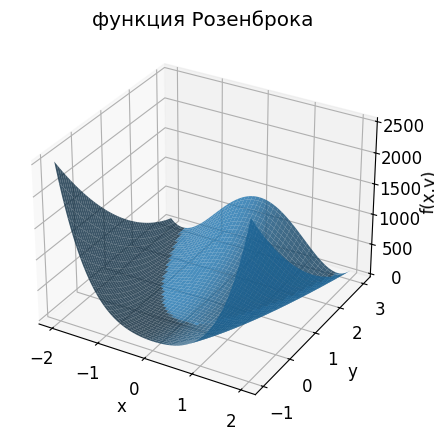

In [43]:
plot_function_3d(rosenbrock, [-2, 2], [-1, 3], title="функция Розенброка")

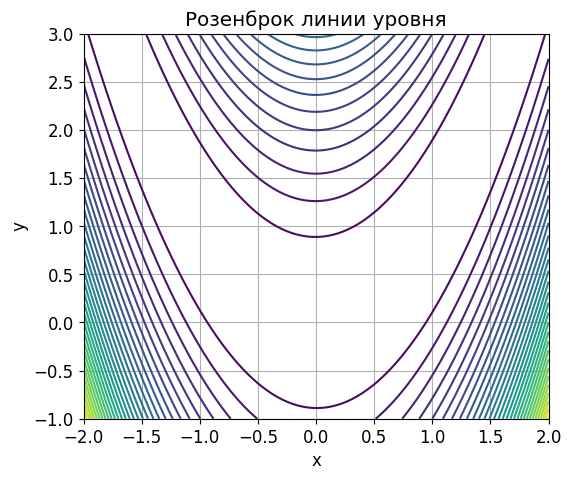

In [44]:
plot_contours_simple(rosenbrock, [-2, 2], [-1, 3], title="Розенброк линии уровня")

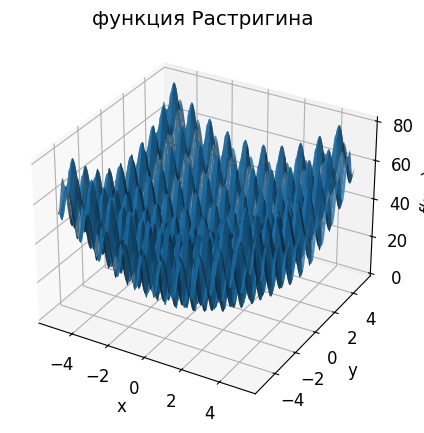

In [45]:
plot_function_3d(rastrigin, [-5.12, 5.12], [-5.12, 5.12], title="функция Растригина")